# AI Adoption and Business Decision-Making: Empirical Analysis

This notebook implements the full data preparation and analysis pipeline for my MSc Business Analytics dissertation.

**Objectives of this notebook:**

1. Clean and preprocess the raw dataset (`AI_Business_Decision_10k.csv`).
2. Engineer relevant variables (e.g. per-employee metrics, AI maturity indicators).
3. Provide descriptive statistics and visualisations of AI adoption and decision outcomes.
4. Estimate multiple regression models to examine:
   - The relationship between AI adoption and decision speed.
   - The relationship between AI adoption and decision accuracy.
   - The relationship between AI adoption and data quality.
5. Perform statistical diagnostics:
   - Residual diagnostics,
   - k-fold cross-validation.
6. Save cleaned data and key outputs for transparency and reproducibility.

The code and outputs demonstrated here are referenced in the Methodology and Findings chapters of the dissertation.


In [3]:
# Imports & configuration

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Plot style
sns.set(style="whitegrid", context="talk")

# Reproducibility
RANDOM_STATE = 42

# File paths (adapt if needed)
DATA_PATH = "AI_Business_Decision_10k.csv"


## 1. Load raw data

In this section, I load the raw 10,000-record dataset and perform an initial inspection
to understand variable types, missing values, and potential data quality issues.


In [4]:
# Load raw data

df_raw = pd.read_csv(DATA_PATH)

print("Raw shape:", df_raw.shape)
display(df_raw.head())
df_raw.info()


Raw shape: (10000, 18)


,Company_ID,Year,Industry,Company_Size,Revenue_GBP,AI_Investment_GBP,AI_Adoption_Pct,AI_Tools_Used,AI_Maturity_Level,Data_Quality_Score,Decision_Accuracy_Pct,Decision_Time_Days,Revenue_Growth_Pct,Employee_Productivity_Index,Customer_Satisfaction_Index,Ethical_Compliance,Scope1_Emissions_Tonnes,Scope2_Emissions_Tonnes
0,C0001,2015,Retail,46956,3.224803e+09,193269.76,28.68,3,Low,6.27,78.37,15.84,4.95,73.58,67.83,No,21920.60,12803.72
1,C0001,2016,Retail,46956,3.471319e+09,140767.21,44.72,3,Medium,6.00,81.76,12.28,7.64,76.31,68.21,No,26307.68,14692.60
2,C0001,2017,Retail,46956,3.432413e+09,225396.57,43.47,3,Medium,6.44,78.13,10.42,3.17,72.36,64.82,No,23399.64,14691.87
3,C0001,2018,Retail,46956,4.286429e+09,216012.89,43.96,2,Medium,7.07,76.14,12.85,9.95,74.32,70.85,Yes,24098.69,16807.15
4,C0001,2019,Retail,46956,4.758817e+09,239754.37,50.18,6,Medium,6.39,87.33,8.96,10.22,73.44,74.51,Yes,30350.75,18308.95


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Company_ID                   10000 non-null  object 
 1   Year                         10000 non-null  int64  
 2   Industry                     10000 non-null  object 
 3   Company_Size                 10000 non-null  int64  
 4   Revenue_GBP                  10000 non-null  float64
 5   AI_Investment_GBP            10000 non-null  float64
 6   AI_Adoption_Pct              10000 non-null  float64
 7   AI_Tools_Used                10000 non-null  int64  
 8   AI_Maturity_Level            10000 non-null  object 
 9   Data_Quality_Score           10000 non-null  float64
 10  Decision_Accuracy_Pct        10000 non-null  float64
 11  Decision_Time_Days           10000 non-null  float64
 12  Revenue_Growth_Pct           10000 non-null  float64
 13  Employee_Producti

## 2. Data cleaning

Cleaning steps in line with the methodology:

1. Remove fully duplicated records.
2. Inspect and handle missing values:
   - Drop rows with missing values in critical outcome variables.
   - Impute remaining missing values in numeric predictors using the median.
3. Ensure that categorical variables are set to the correct data type.


In [5]:
# Copy raw data to preserve original
df = df_raw.copy()

# 2.1 Remove duplicates
dup_count = df.duplicated().sum()
print(f"Number of fully duplicated rows: {dup_count}")
df = df.drop_duplicates()

# 2.2 Check missing values
missing = df.isna().sum().sort_values(ascending=False)
print("Missing values per column:\n", missing)

# Define critical outcome variables (adjust if your column names differ)
critical_cols = [
    "Decision_Accuracy_Pct",
    "Decision_Time_Days",
    "Data_Quality_Score",
    "AI_Adoption_Pct",
]

# Drop rows with missing values in critical outcome variables
df = df.dropna(subset=critical_cols)

# Impute remaining missing numeric values with median
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df[col].isna().sum() > 0:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        print(f"Filled NaNs in {col} with median {median_val:.2f}")

# 2.3 Set categorical dtypes (change list if your variables differ)
categorical_cols = ["Company_ID", "Industry", "AI_Maturity_Level", "Ethical_Compliance"]
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype("category")

print("\nDtypes after cleaning:\n", df.dtypes)
print("\nCleaned shape:", df.shape)


Number of fully duplicated rows: 0
Missing values per column:
 Company_ID                     0
Year                           0
Industry                       0
Company_Size                   0
Revenue_GBP                    0
AI_Investment_GBP              0
AI_Adoption_Pct                0
AI_Tools_Used                  0
AI_Maturity_Level              0
Data_Quality_Score             0
Decision_Accuracy_Pct          0
Decision_Time_Days             0
Revenue_Growth_Pct             0
Employee_Productivity_Index    0
Customer_Satisfaction_Index    0
Ethical_Compliance             0
Scope1_Emissions_Tonnes        0
Scope2_Emissions_Tonnes        0
dtype: int64

Dtypes after cleaning:
 Company_ID                     category
Year                              int64
Industry                       category
Company_Size                      int64
Revenue_GBP                     float64
AI_Investment_GBP               float64
AI_Adoption_Pct                 float64
AI_Tools_Used            

## 3. Feature engineering

In this step I engineer additional variables to better capture firm-level differences:

- **Revenue_per_Employee** = Revenue / Company_Size  
- **AI_Invest_per_Employee** = AI_Investment / Company_Size  
- **Revenue_Growth_Computed** = Percentage change in revenue per firm-year  
- **AI_Maturity_Num** = numeric coding of AI maturity levels (Low=1, Medium=2, High=3)

These transformations are consistent with the methodological discussion on normalisation and scaling.

In [7]:
# Sort by firm and year for time-based operations
if {"Company_ID", "Year"}.issubset(df.columns):
    df = df.sort_values(["Company_ID", "Year"])

# 3.1 Per-employee metrics (adjust names if needed)
if {"Revenue_GBP", "Company_Size"}.issubset(df.columns):
    df["Revenue_per_Employee"] = df["Revenue_GBP"] / df["Company_Size"]

if {"AI_Investment_GBP", "Company_Size"}.issubset(df.columns):
    df["AI_Invest_per_Employee"] = df["AI_Investment_GBP"] / df["Company_Size"]

# 3.2 Within-company revenue growth (if Year exists)
if {"Company_ID", "Revenue_GBP", "Year"}.issubset(df.columns):
    df["Revenue_Growth_Computed"] = (
        df.groupby("Company_ID")["Revenue_GBP"].pct_change() * 100
    )

# 3.3 Numeric AI maturity indicator
maturity_order = {"Low": 1, "Medium": 2, "High": 3}
if "AI_Maturity_Level" in df.columns:
    df["AI_Maturity_Num"] = df["AI_Maturity_Level"].map(maturity_order)

df[["AI_Maturity_Level", "AI_Maturity_Num"]].head()


C:\Users\BARATH SANJAY\AppData\Local\Temp\ipykernel_24976\765544013.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("Company_ID")["Revenue_GBP"].pct_change() * 100


,AI_Maturity_Level,AI_Maturity_Num
0,Low,1
1,Medium,2
2,Medium,2
3,Medium,2
4,Medium,2


## 4. Descriptive statistics and distributions

This section provides:

- Summary statistics for key variables.
- Grouped means by AI maturity and industry.
- Histograms to inspect distributions of AI adoption, decision speed, decision accuracy, and related performance metrics.


,Year,Company_Size,Revenue_GBP,AI_Investment_GBP,AI_Adoption_Pct,AI_Tools_Used,Data_Quality_Score,Decision_Accuracy_Pct,Decision_Time_Days,Revenue_Growth_Pct,Employee_Productivity_Index,Customer_Satisfaction_Index,Scope1_Emissions_Tonnes,Scope2_Emissions_Tonnes,Revenue_per_Employee,AI_Invest_per_Employee,Revenue_Growth_Computed
count,10000.000000,10000.000000,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,9000.000000
mean,2019.500000,25323.890000,1.360521e+10,2.171453e+05,45.654546,3.799600,6.982819,80.741957,10.051637,6.496209,76.774891,68.997447,22322.189712,13467.767091,1.997025e+06,36.086222,9.071291
std,2.872425,14775.390073,8.796137e+09,3.468874e+05,8.920546,1.282421,1.890370,5.036569,2.495720,2.999335,8.707977,4.337119,31084.455160,19978.970276,1.069506e+07,268.132447,23.231517
min,2015.000000,74.000000,1.103466e+07,1.114025e+04,14.540000,0.000000,1.000000,62.010000,1.990000,-4.340000,46.180000,51.170000,70.510000,21.680000,2.729055e+02,0.261294,-62.436606
25%,2017.000000,11878.000000,6.615198e+09,4.700456e+04,39.270000,3.000000,5.700000,77.390000,8.300000,4.440000,70.930000,66.047500,3395.267500,1889.495000,2.605236e+05,2.013433,-2.714297
50%,2019.500000,25573.000000,1.292043e+10,1.052112e+05,45.640000,4.000000,7.070000,80.900000,10.020000,6.520000,76.940000,68.990000,9229.405000,5262.990000,5.148038e+05,5.226212,6.465842
75%,2022.000000,38181.750000,1.917109e+10,2.516220e+05,52.002500,5.000000,8.410000,84.262500,11.750000,8.530000,82.862500,71.952500,24671.722500,14488.572500,1.138934e+06,15.525436,17.142463
max,2024.000000,49985.000000,6.404826e+10,4.799306e+06,74.540000,9.000000,10.000000,96.090000,20.700000,20.260000,111.360000,88.290000,173825.890000,138688.540000,5.229195e+08,7703.541348,194.169999



Mean decision metrics by AI maturity:



,Decision_Time_Days,Decision_Accuracy_Pct,Data_Quality_Score
AI_Maturity_Level,,,
High,7.632500,85.887500,7.295000
Low,11.438878,77.756714,6.402066
Medium,9.528573,81.867687,7.203344



Mean decision metrics by Industry:



,Decision_Time_Days,Decision_Accuracy_Pct,Data_Quality_Score
Industry,,,
Finance,10.054541,80.849815,6.970327
Healthcare,10.101953,80.550349,6.934994
Manufacturing,10.062966,80.616125,6.942543
Retail,9.969079,80.934406,7.076445
Technology,10.095145,80.714036,6.974012


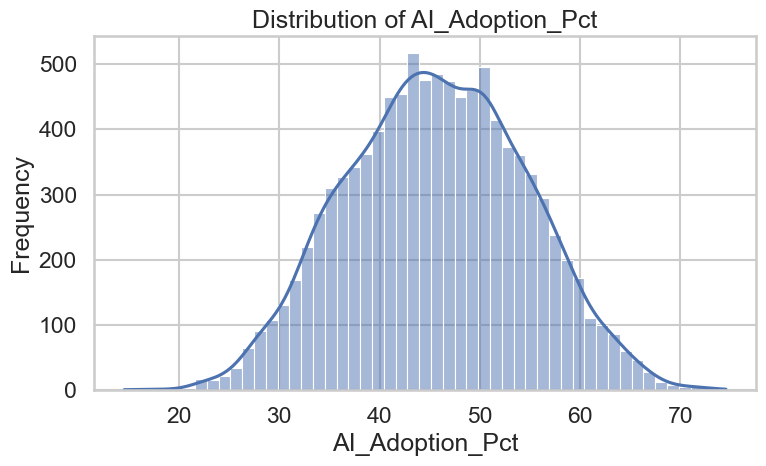

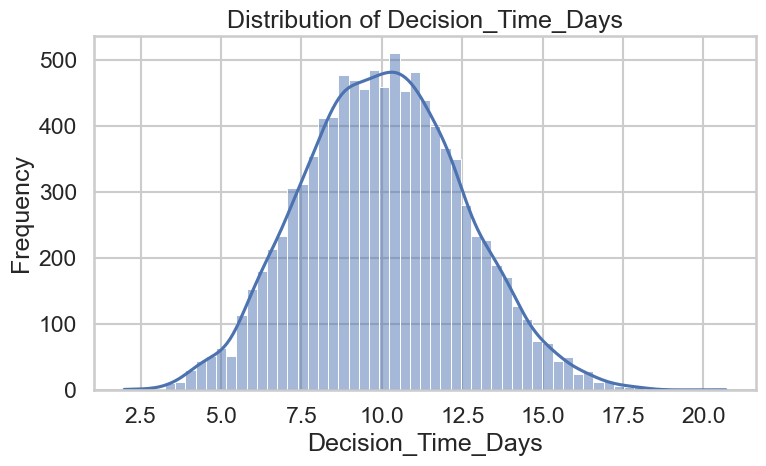

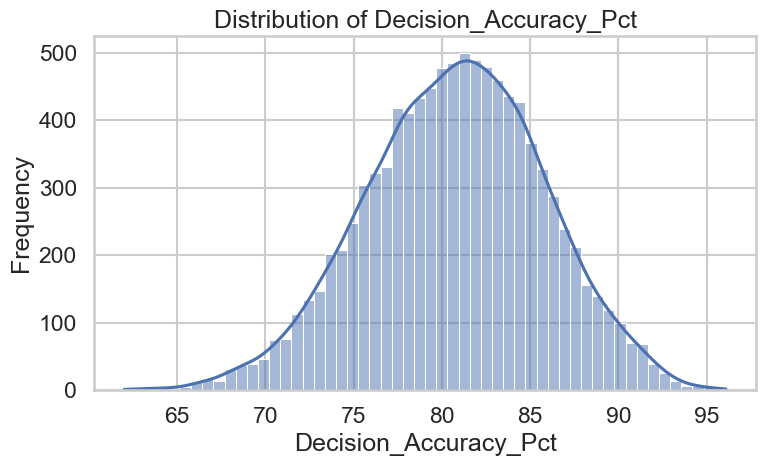

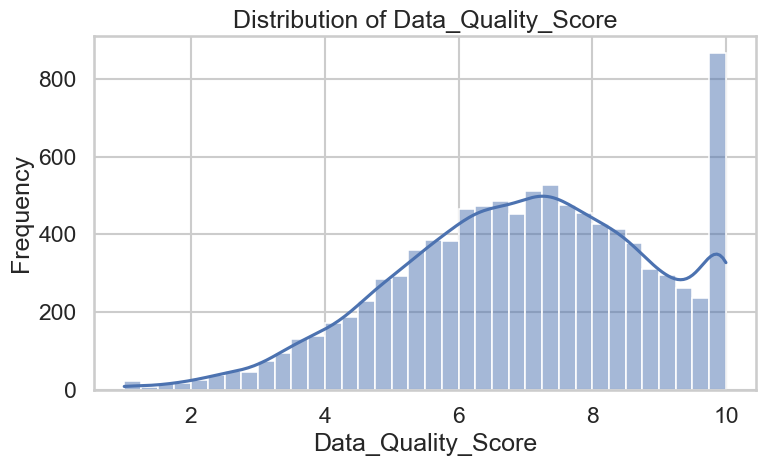

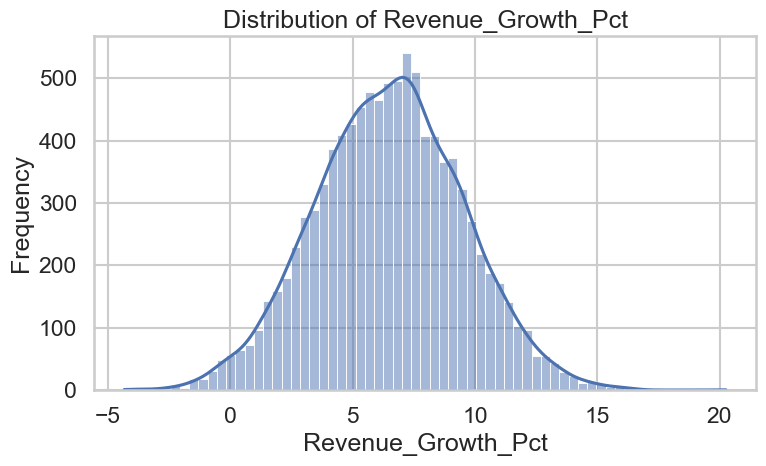

In [9]:
# Overall descriptive statistics
desc = df.describe()
display(desc)

# Grouped means by AI maturity
group_maturity_cols = ["Decision_Time_Days", "Decision_Accuracy_Pct", "Data_Quality_Score"]
if "AI_Maturity_Level" in df.columns:
    desc_maturity = df.groupby("AI_Maturity_Level", observed=False)[group_maturity_cols].mean()
    print("\nMean decision metrics by AI maturity:\n")
    display(desc_maturity)

# Grouped means by Industry
if "Industry" in df.columns:
    desc_industry = df.groupby("Industry", observed=False)[group_maturity_cols].mean()
    print("\nMean decision metrics by Industry:\n")
    display(desc_industry)

# Histograms for selected numeric variables
numeric_to_plot = [
    "AI_Adoption_Pct",
    "Decision_Time_Days",
    "Decision_Accuracy_Pct",
    "Data_Quality_Score",
    "Revenue_Growth_Pct",
]

for col in numeric_to_plot:
    if col in df.columns:
        plt.figure(figsize=(8, 5))
        sns.histplot(df[col], kde=True)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()


## 5. Correlation analysis

Here I compute a correlation matrix for the key variables capturing AI adoption, data quality, and decision performance. A heatmap is used to visualise the strength and direction of pairwise relationships.



Correlation matrix:



,AI_Adoption_Pct,AI_Maturity_Num,Decision_Time_Days,Decision_Accuracy_Pct,Data_Quality_Score,Revenue_Growth_Pct,Employee_Productivity_Index,Customer_Satisfaction_Index
AI_Adoption_Pct,1.000000,0.764884,-0.445322,0.476624,0.245709,0.097622,0.522660,0.189672
AI_Maturity_Num,0.764884,1.000000,-0.344039,0.366814,0.188831,0.065647,0.402911,0.128257
Decision_Time_Days,-0.445322,-0.344039,1.000000,-0.638956,-0.752244,-0.065951,-0.653226,-0.252434
Decision_Accuracy_Pct,0.476624,0.366814,-0.638956,1.000000,0.741041,0.075605,0.653683,0.361348
Data_Quality_Score,0.245709,0.188831,-0.752244,0.741041,1.000000,0.049741,0.734938,0.294865
Revenue_Growth_Pct,0.097622,0.065647,-0.065951,0.075605,0.049741,1.000000,0.067648,0.039336
Employee_Productivity_Index,0.522660,0.402911,-0.653226,0.653683,0.734938,0.067648,1.000000,0.301316
Customer_Satisfaction_Index,0.189672,0.128257,-0.252434,0.361348,0.294865,0.039336,0.301316,1.000000


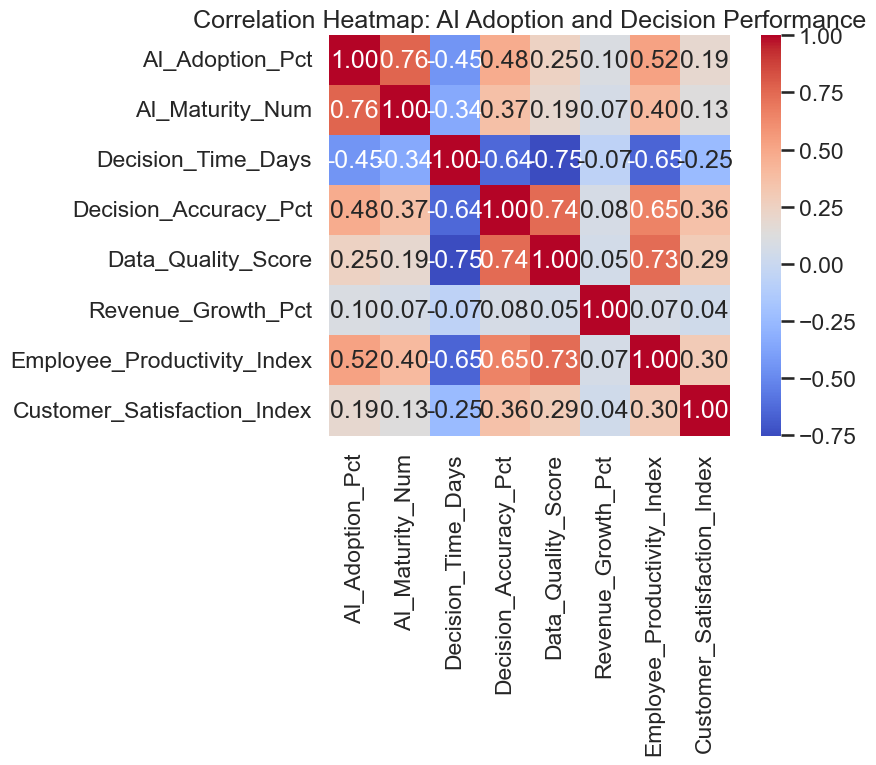

In [10]:
corr_vars = [
    "AI_Adoption_Pct",
    "AI_Maturity_Num",
    "Decision_Time_Days",
    "Decision_Accuracy_Pct",
    "Data_Quality_Score",
    "Revenue_Growth_Pct",
    "Employee_Productivity_Index",
    "Customer_Satisfaction_Index",
]

available_corr_vars = [v for v in corr_vars if v in df.columns]

corr_matrix = df[available_corr_vars].corr()
print("\nCorrelation matrix:\n")
display(corr_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap: AI Adoption and Decision Performance")
plt.tight_layout()
plt.show()


## 6. Regression models

I estimate three OLS models to test the main hypotheses:

1. **Model 1 (Decision speed)**  
   `Decision_Time_Days ~ AI_Adoption_Pct + AI_Maturity_Num + Company_Size + Revenue_Growth_Pct + Industry controls`

2. **Model 2 (Decision accuracy)**  
   `Decision_Accuracy_Pct ~ AI_Adoption_Pct + AI_Maturity_Num + Data_Quality_Score + Company_Size + Industry controls`

3. **Model 3 (Data quality)**  
   `Data_Quality_Score ~ AI_Adoption_Pct + AI_Maturity_Num + Company_Size + Industry controls`

Categorical industry effects are modelled using dummy variables via `C(Industry)` in the formula syntax.


In [11]:
# Select columns needed for modelling
model_cols = [
    "Decision_Time_Days",
    "Decision_Accuracy_Pct",
    "Data_Quality_Score",
    "AI_Adoption_Pct",
    "AI_Maturity_Level",
    "AI_Maturity_Num",
    "Company_Size",
    "Industry",
    "Revenue_Growth_Pct",
]

df_model = df[model_cols].dropna().copy()
print("Shape of modelling dataset:", df_model.shape)

# Model 1: Decision speed
formula_speed = (
    "Decision_Time_Days ~ AI_Adoption_Pct + AI_Maturity_Num "
    "+ Company_Size + Revenue_Growth_Pct + C(Industry)"
)

model_speed = smf.ols(formula=formula_speed, data=df_model).fit()
print("\n=== Model 1: Decision_Time_Days ===")
display(model_speed.summary())

# Model 2: Decision accuracy
formula_accuracy = (
    "Decision_Accuracy_Pct ~ AI_Adoption_Pct + AI_Maturity_Num "
    "+ Data_Quality_Score + Company_Size + C(Industry)"
)

model_accuracy = smf.ols(formula=formula_accuracy, data=df_model).fit()
print("\n=== Model 2: Decision_Accuracy_Pct ===")
display(model_accuracy.summary())

# Model 3: Data quality
formula_quality = (
    "Data_Quality_Score ~ AI_Adoption_Pct + AI_Maturity_Num "
    "+ Company_Size + C(Industry)"
)

model_quality = smf.ols(formula=formula_quality, data=df_model).fit()
print("\n=== Model 3: Data_Quality_Score ===")
display(model_quality.summary())


Shape of modelling dataset: (10000, 9)

=== Model 1: Decision_Time_Days ===


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Decision_Time_Days   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     279.1
Date:                Wed, 03 Dec 2025   Prob (F-statistic):               0.00
Time:                        13:57:04   Log-Likelihood:                -22213.
No. Observations:               10000   AIC:                         4.445e+04
Df Residuals:                    9990   BIC:                         4.452e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       16.7358      0.628     26.650      0.000      15.505      17.967
AI_Maturity_Num[T.1]            -0.7556      0.578     -1.307      0.191      -1.889       0.378
AI_Maturity_Num[T.2]            -0.8054      0.565     -1.425      0.154      -1.913       0.303
C(Industry)[T.Healthcare]        0.0039      0.074      0.053      0.958      -0.140       0.148
C(Industry)[T.Manufacturing]     0.0076      0.068      0.112      0.911      -0.125       0.140
C(Industry)[T.Retail]           -0.0767      0.068     -1.128      0.259      -0.210       0.057
C(Industry)[T.Technology]        0.0787      0.074      1.064      0.287      -0.066       0.224
AI_Adoption_Pct                 -0.1227      0.004    -31.458      0.000      -0.130      -0.115
Company_Size                 -6.544e-06   1.52e-06     -4.313      0.000   -9.52e-06   -3.57e-06
Revenue_Growth_Pct              -0.0191      0.007     -2.560      0.010      -0.034      -0.004
==============================================================================
Omnibus:                       19.628   Durbin-Watson:                   1.158
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.349
Skew:                           0.095   Prob(JB):                     6.29e-05
Kurtosis:                       2.899   Cond. No.                     1.33e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.33e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""


=== Model 2: Decision_Accuracy_Pct ===


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Decision_Accuracy_Pct   R-squared:                       0.642
Model:                               OLS   Adj. R-squared:                  0.641
Method:                    Least Squares   F-statistic:                     1988.
Date:                   Wed, 03 Dec 2025   Prob (F-statistic):               0.00
Time:                           13:57:04   Log-Likelihood:                -25223.
No. Observations:                  10000   AIC:                         5.047e+04
Df Residuals:                       9990   BIC:                         5.054e+04
Df Model:                              9                                         
Covariance Type:               nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       60.5177      0.849     71.286      0.000      58.854      62.182
AI_Maturity_Num[T.1]            -0.0506      0.781     -0.065      0.948      -1.582       1.481
AI_Maturity_Num[T.2]            -0.0085      0.764     -0.011      0.991      -1.506       1.489
C(Industry)[T.Healthcare]       -0.2098      0.099     -2.110      0.035      -0.405      -0.015
C(Industry)[T.Manufacturing]    -0.1941      0.091     -2.121      0.034      -0.373      -0.015
C(Industry)[T.Retail]           -0.1397      0.092     -1.519      0.129      -0.320       0.041
C(Industry)[T.Technology]       -0.2163      0.100     -2.166      0.030      -0.412      -0.021
AI_Adoption_Pct                  0.1755      0.005     32.951      0.000       0.165       0.186
Data_Quality_Score               1.7685      0.016    107.301      0.000       1.736       1.801
Company_Size                  1.233e-06   2.05e-06      0.601      0.548   -2.79e-06    5.25e-06
==============================================================================
Omnibus:                        0.778   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.678   Jarque-Bera (JB):                0.749
Skew:                           0.019   Prob(JB):                        0.688
Kurtosis:                       3.020   Cond. No.                     1.33e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.33e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""


=== Model 3: Data_Quality_Score ===


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Data_Quality_Score   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     83.76
Date:                Wed, 03 Dec 2025   Prob (F-statistic):          7.52e-135
Time:                        13:57:04   Log-Likelihood:                -20232.
No. Observations:               10000   AIC:                         4.048e+04
Df Residuals:                    9991   BIC:                         4.055e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        3.4101      0.514      6.632      0.000       2.402       4.418
AI_Maturity_Num[T.1]             1.0474      0.474      2.209      0.027       0.118       1.977
AI_Maturity_Num[T.2]             1.0601      0.464      2.286      0.022       0.151       1.969
C(Industry)[T.Healthcare]       -0.0093      0.060     -0.155      0.877      -0.128       0.109
C(Industry)[T.Manufacturing]    -0.0241      0.056     -0.433      0.665      -0.133       0.085
C(Industry)[T.Retail]            0.1099      0.056      1.970      0.049       0.001       0.219
C(Industry)[T.Technology]       -0.0072      0.061     -0.118      0.906      -0.126       0.112
AI_Adoption_Pct                  0.0522      0.003     16.372      0.000       0.046       0.058
Company_Size                  4.594e-06   1.24e-06      3.692      0.000    2.15e-06    7.03e-06
==============================================================================
Omnibus:                      217.171   Durbin-Watson:                   0.476
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              201.461
Skew:                          -0.303   Prob(JB):                     1.79e-44
Kurtosis:                       2.660   Cond. No.                     1.33e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.33e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 7. Model diagnostics

To assess the robustness of the regression results, I conduct:
1. **Residual diagnostics** using residual vs fitted plots and Q-Q plots.  
2. **Out-of-sample performance** via 5-fold cross-validation on the accuracy model.


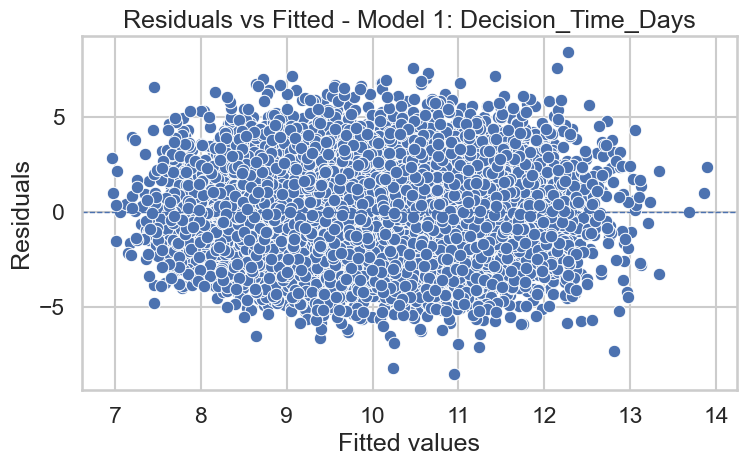

<Figure size 600x600 with 0 Axes>

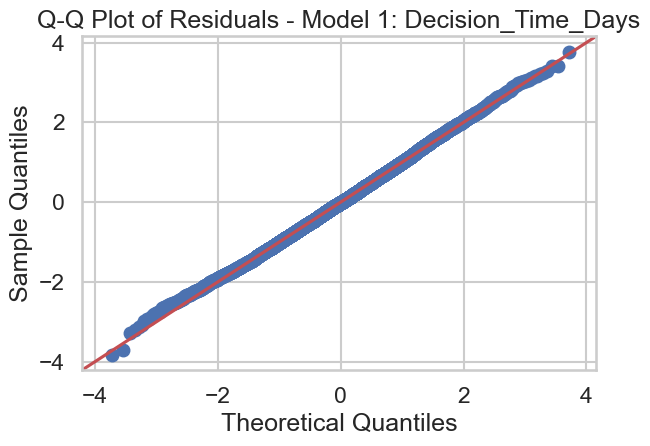

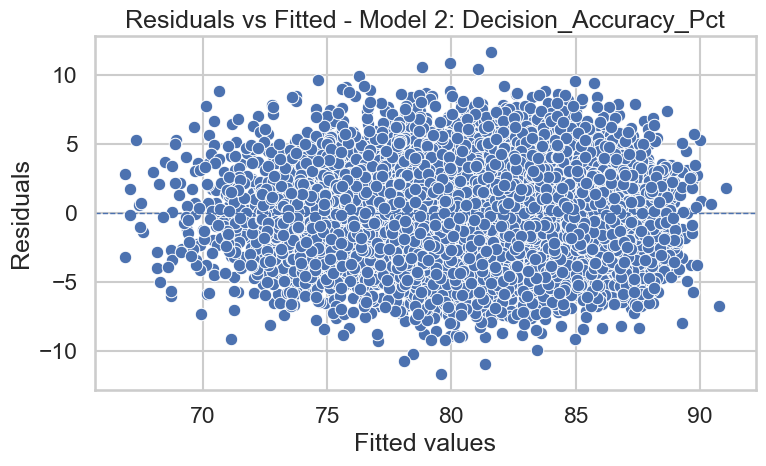

<Figure size 600x600 with 0 Axes>

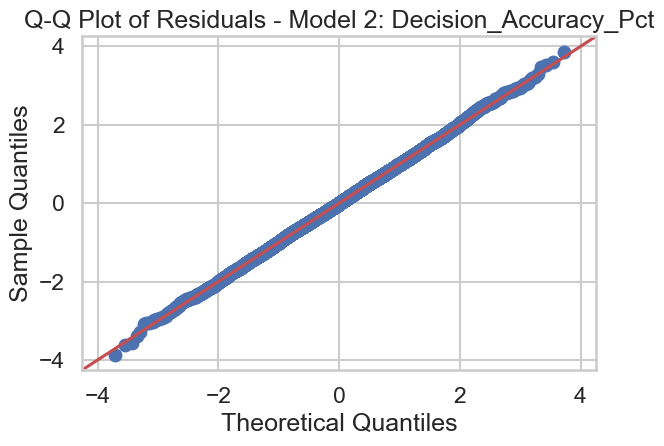

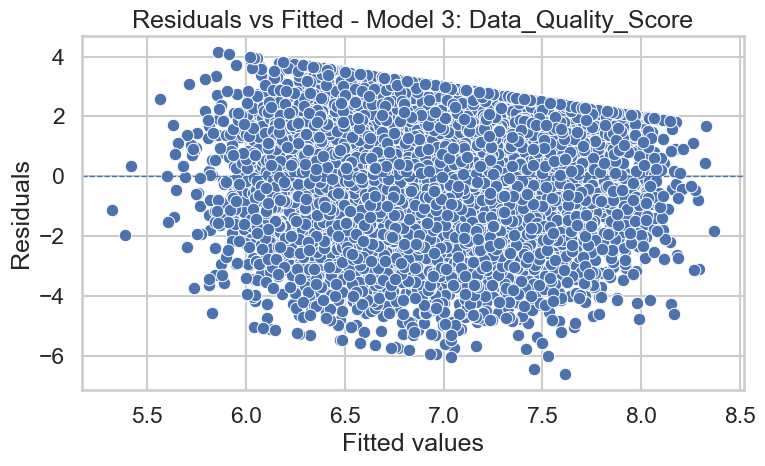

<Figure size 600x600 with 0 Axes>

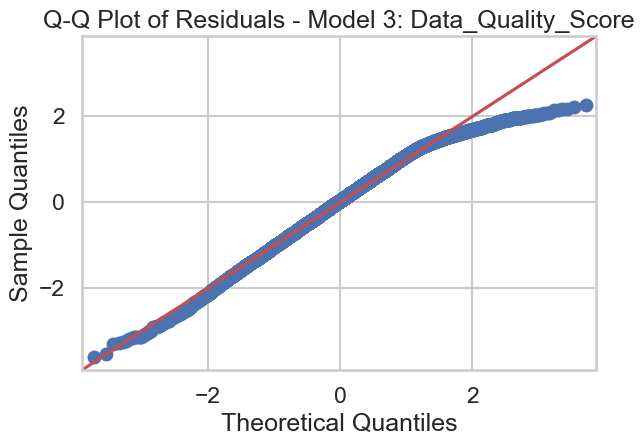

In [13]:
def plot_residual_diagnostics(model, model_name):
    residuals = model.resid
    fitted = model.fittedvalues

    # Residuals vs Fitted
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=fitted, y=residuals)
    plt.axhline(0, linestyle="--", linewidth=1)
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.title(f"Residuals vs Fitted - {model_name}")
    plt.tight_layout()
    plt.show()

    # Q-Q plot for normality
    plt.figure(figsize=(6, 6))
    sm.qqplot(residuals, line="45", fit=True)
    plt.title(f"Q-Q Plot of Residuals - {model_name}")
    plt.tight_layout()
    plt.show()

plot_residual_diagnostics(model_speed, "Model 1: Decision_Time_Days")
plot_residual_diagnostics(model_accuracy, "Model 2: Decision_Accuracy_Pct")
plot_residual_diagnostics(model_quality, "Model 3: Data_Quality_Score")


In [14]:
# 5-fold CV for Decision_Accuracy_Pct model using scikit-learn

features_cv = [
    "AI_Adoption_Pct",
    "AI_Maturity_Num",
    "Data_Quality_Score",
    "Company_Size",
    "Revenue_Growth_Pct",
]

X_cv = df_model[features_cv].values
y_cv = df_model["Decision_Accuracy_Pct"].values

# Standardise predictors
scaler = StandardScaler()
X_cv_scaled = scaler.fit_transform(X_cv)

lin_reg = LinearRegression()

kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores = cross_val_score(lin_reg, X_cv_scaled, y_cv, cv=kfold, scoring="r2")

print("5-fold Cross-Validation R² scores for Decision_Accuracy_Pct model:")
print(cv_scores)
print("Mean R²:", np.mean(cv_scores))


5-fold Cross-Validation R² scores for Decision_Accuracy_Pct model:
[0.63687998 0.65236852 0.6402334  0.63063554 0.64369278]
Mean R²: 0.6407620441531514


## 8. Save cleaned data and key outputs

For transparency and reproducibility, I export:

- The cleaned dataset with engineered variables.  
- The correlation matrix.  
- Plain-text regression summaries (to be used in the dissertation appendix).

These files are stored in an `outputs/` folder within the GitHub repository.


In [15]:
import os

# Ensure outputs directory exists
os.makedirs("outputs", exist_ok=True)

# 8.1 Save cleaned dataset
df.to_csv("outputs/AI_Business_Decision_10k_cleaned.csv", index=False)

# 8.2 Save correlation matrix
corr_matrix.to_csv("outputs/correlation_matrix.csv")

# 8.3 Save regression summaries
with open("outputs/regression_summaries.txt", "w") as f:
    f.write("=== Model 1: Decision_Time_Days ===\n")
    f.write(str(model_speed.summary()))
    f.write("\n\n=== Model 2: Decision_Accuracy_Pct ===\n")
    f.write(str(model_accuracy.summary()))
    f.write("\n\n=== Model 3: Data_Quality_Score ===\n")
    f.write(str(model_quality.summary()))

print("Saved cleaned dataset and key outputs to 'outputs/' directory.")


Saved cleaned dataset and key outputs to 'outputs/' directory.


## 9. Summary

This notebook implemented the full empirical pipeline described in the dissertation:

- Cleaned and preprocessed the raw 10k-record dataset.
- Engineered firm-level and AI maturity variables.
- Provided descriptive statistics and visualisations of AI adoption and decision outcomes.
- Estimated three regression models focusing on decision speed, accuracy, and data quality.
- Conducted diagnostic checks (residual analysis, cross-validation).
- Exported cleaned data and model outputs for inclusion in the dissertation appendix.

The notebook and associated outputs are made publicly available in the GitHub repository:

`https://github.com/<your-username>/ai-business-decision-dissertation`

